# **Implementation of Frechet Inception Distance (FID) and Kernel Inception Distance (KID)**

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Evaluating Generative Performance**

We're reaching a point where our generated images are getting good enough to actually bias our own perception of what a _good image_ actually looks like. We need to be able to measure the quality of these generated images against a real life benchmark. The benchmark is an actual human being's comparison of generated images and a set of real images using the good old "mark-one eyeball" approach.

While the research community is constantly finding new ways to mathematically measure the difference between the two, the most commonly used metric is called the [Frechet Inception Distance](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance).

> The Frechet Inception Distance score, or FID for short, is a metric that calculates the distance between feature vectors calculated for real and generated images.
>
>The score summarizes how similar the two groups are in terms of statistics on computer vision features of the raw images calculated using the inception v3 model used for image classification. Lower scores indicate the two groups of images are more similar, or have more similar statistics, with a perfect score being 0.0 indicating that the two groups of images are identical.
>
>The FID score is used to evaluate the quality of images generated by generative adversarial networks, and lower scores have been shown to correlate well with higher quality images.

## **Setup CLassifier**

To implement FID, we will use our existing model `fashion_ddpm_mp` which was trained using mixed precision. It will be referred to as the `sample model` or `smodel`.

In [8]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 512

# `*2-1` ensures the image range is normalized to (-1, 1) from NB 14 - Section AUGMENT 2
# This was to move away from subtracting the mean and dividing the standard deviation
# Also, in DDPM_V2, our transformation resulted in images ranging (0, 1) which is incorrect.
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [9]:
b = xb, yb = next(iter(dls.train))

In [10]:
cbs = [DeviceCB(), MixedPrecision()]
model = torch.load('models/data_aug2.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

In [11]:
# Simple function to append the output using hooks
def append_outp(hook, mode, inp, outp):
    if not hasattr(hook, 'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [12]:
# The above function will take the output of the pooling layer (details below) by
# referencing the specific module of the pretrained model.
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

In [13]:
# This implementation needs work since we're obviously not training the model.
# We're just passing a batch through the model and grabbing the outputs.
# Hence setting train=False makes sense.
learn.fit(1, train=False, cbs=[hcb])

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [14]:
# The hook now contains .outp as an attribute from the function above
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

This was just one simple approach to extract features. Another approach would be to leverage the Sequential model's property of having [collections](https://docs.python.org/3/library/collections.html). Collections allow us to delete specific layers from our Sequential model, namely the final two. This automatically truncates the model to the pooling layers.

All that remains is calling `capture_preds()`. This approach has the benefit of returning the 10,000 images in the test set.

In [15]:
del(learn.model[8])
del(learn.model[7])

In [16]:
feats, y = learn.capture_preds()
feats = feats.float()
feats.shape, y

(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## **Calculate FID**

In [17]:
beta_min, beta_max, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(beta_min, beta_max, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [18]:
# Carrying over the noisify function from before
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)

def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [19]:
dls2 = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [20]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [21]:
# Load sample model
smodel = torch.load('models/fashion_ddpm_mp.pkl').cuda()

In [22]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_0_hat.cpu())
    return preds

Grabbing 256 images for this run.

In [23]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 50.9 s, sys: 2.15 s, total: 53 s
Wall time: 52.7 s


In [24]:
# Samples were generated having a range of (0, 1) so we will need to transform
# them to have a range of (-1, 1) to match the comparison model.
s = samples[-1]*2-1

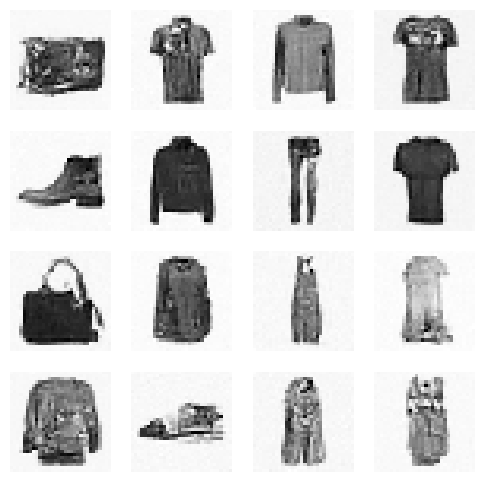

In [25]:
show_images(s[:16], imsize=1.5)

Taking 4 of the previously trained model's generated samples, we look at some statistics of select activations. Recall that we created `summary()` for the `TrainLearner`, which returns various output shapes of each layer of our model.

![title](imgs/table_summary.png)

We will take our samples and run them through the model which is pretrained to predict fashion classes. Afterwards, the pooling layer titled `GlobalAvgPool`, will be extracted and the mean of each of the channel across the batch size will calculated.

Channels would contain different feature characteristics from the fashion dataset, so the mean would be representative of the distributions of these characteristics.

In [26]:
# Create a new DataLoader which contains no training batches. It does contain one
# validation batch with the samples from above. 
# This is the classifier learner from the previous section, so the model passed here is pretrained.
clearn = TrainLearner(model, DataLoaders([], [(s, yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2, y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

In [27]:
# Take the mean of channel features
means = feats.mean(0)
means.shape

torch.Size([512])

Means alone don't really tell us much, since we are averaging the entire batch. We will also need a `512x512` covariance matrix. This will allow us to compare covariance matrices of the samples and the actuals.

In [28]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [33]:
# This function calculates the square root of a matric using the Newton method.
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_nrm = mat.norm() # Carry out matrix normalization (Frobenius norm)
    mat = mat.double() # Matrix type conversion to double precision to improve fp accuracy
    Y = mat / mat_nrm # normalize mat
    n = len(mat) # Assume matrix is square
    I = torch.eye(n, n).to(mat) #torch.eye() returns a 2D Identity matrix
    Z = torch.eye(n, n).to(mat)

    for i in range(num_iters): # Newton Schulz iterative method
        T = (3*I - Z@I) / 2 # Update matrix T based on current estimate of Z
        # Update Y which refines the estimate of the sq.root of mat
        # Update Z which adjusts the inverse estimate
        Y, Z = Y@T, T@Z  
        # Y is scaled back to its original magnitude
        res = Y*mat_nrm.sqrt()
        # Convergence check. Compute the norm of the difference b/w original and square of
        # current estimate.
        if ((mat - (res@res)).norm() / mat_nrm).abs() <= 1e-6: break
    return res

In [34]:
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0), feats.T.cov()

def _calc_fid(m1, c1, m2, c2):
    # Multiply the two covariance matrices and rescale / renormalize using the matrix square root.
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [31]:
s1, s2 = _calc_stats(feats), _calc_stats(feats2)

In [32]:
_calc_fid(*s1, *s2)

28.98077392578125